In [1]:
import os
import sys
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import accuracy_score, classification_report



In [2]:
price_data = pd.read_csv('dataset.csv')
price_data.head()

,srno.,close,datetime,high,low,open,symbol,volume
0,0,105.51,1513144800000,107.11,105.48,106.70,JPM,15020293
1,1,104.66,1513231200000,106.45,104.64,106.12,JPM,13034232
2,2,106.14,1513317600000,106.52,105.20,105.79,JPM,29350598
3,3,106.96,1513576800000,107.63,106.48,107.19,JPM,12713148
4,4,106.51,1513663200000,107.49,106.44,107.35,JPM,12149937


In [3]:
# I Just need the Close
price_data = price_data[['symbol','datetime','close','high','low','open','volume']]

# sort the values by symbol and then date
price_data.sort_values(by = ['symbol','datetime'], inplace = True)

# calculate the change in price
price_data['change_in_price'] = price_data['close'].diff()

In [4]:
# identify rows where the symbol changes
mask = price_data['symbol'] != price_data['symbol'].shift(1)

# For those rows, let's make the value null
price_data['change_in_price'] = np.where(mask == True, np.nan, price_data['change_in_price'])

# print the rows that have a null value, should only be 5
price_data[price_data.isna().any(axis = 1)]

,symbol,datetime,close,high,low,open,volume,change_in_price
2016,ARWR,1513144800000,3.40,3.41,3.01,3.30,2037395,NaN
504,COST,1513144800000,188.28,190.12,187.80,188.53,3062856,NaN
1512,HD,1513144800000,183.03,183.67,182.00,182.01,5177363,NaN
1008,IBM,1513144800000,153.91,156.73,153.89,156.60,5661618,NaN
0,JPM,1513144800000,105.51,107.11,105.48,106.70,15020293,NaN


In [5]:
# define the number of days out you want to predict
days_out = 30

# Group by symbol, then apply the rolling function and grab the Min and Max.
price_data_smoothed = price_data.groupby(['symbol'])[['close','low','high','open','volume']].transform(lambda x: x.ewm(span = days_out).mean())

# Join the smoothed columns with the symbol and datetime column from the old data frame.
smoothed_df = pd.concat([price_data[['symbol','datetime']], price_data_smoothed], axis=1, sort=False)

smoothed_df

,symbol,datetime,close,low,high,open,volume
2016,ARWR,1513144800000,3.400000,3.010000,3.410000,3.300000,2.037395e+06
2017,ARWR,1513231200000,3.270833,3.030667,3.415167,3.356833,1.864160e+06
2018,ARWR,1513317600000,3.224284,3.048219,3.338612,3.297475,1.665444e+06
2019,ARWR,1513576800000,3.225859,3.073508,3.354149,3.256840,1.552160e+06
2020,ARWR,1513663200000,3.233627,3.108454,3.360030,3.255284,1.455788e+06
...,...,...,...,...,...,...,...
499,JPM,1575871200000,129.393379,128.616819,129.991328,129.207780,9.662265e+06
500,JPM,1575957600000,129.722838,128.891863,130.299629,129.468569,9.524893e+06
501,JPM,1576044000000,130.010397,129.222066,130.604169,129.779629,9.491834e+06
502,JPM,1576130400000,130.527146,129.543868,131.111642,130.083524,9.764989e+06


In [6]:
# define the number of days out you want to predict
days_out = 30

# create a new column that will house the flag, and for each group calculate the diff compared to 30 days ago. Then use Numpy to define the sign.
smoothed_df['Signal_Flag'] = smoothed_df.groupby('symbol')['close'].transform(lambda x : np.sign(x.diff(days_out)))

# print the first 50 rows
smoothed_df.head(50)

,symbol,datetime,close,low,high,open,volume,Signal_Flag
2016,ARWR,1513144800000,3.400000,3.010000,3.410000,3.300000,2.037395e+06,NaN
2017,ARWR,1513231200000,3.270833,3.030667,3.415167,3.356833,1.864160e+06,NaN
2018,ARWR,1513317600000,3.224284,3.048219,3.338612,3.297475,1.665444e+06,NaN
2019,ARWR,1513576800000,3.225859,3.073508,3.354149,3.256840,1.552160e+06,NaN
2020,ARWR,1513663200000,3.233627,3.108454,3.360030,3.255284,1.455788e+06,NaN
2021,ARWR,1513749600000,3.272044,3.140058,3.404042,3.262076,1.440693e+06,NaN
2022,ARWR,1513836000000,3.290716,3.179828,3.427522,3.285931,1.382798e+06,NaN
2023,ARWR,1513922400000,3.356139,3.217928,3.489808,3.311531,1.478588e+06,NaN
2024,ARWR,1514268000000,3.418161,3.275405,3.542728,3.367064,1.417962e+06,NaN
2025,ARWR,1514354400000,3.474078,3.339773,3.591412,3.427103,1.396085e+06,NaN


In [7]:
# Calculate the 14 day RSI
n = 14

# First make a copy of the data frame twice
up_df, down_df = price_data[['symbol','change_in_price']].copy(), price_data[['symbol','change_in_price']].copy()

# For up days, if the change is less than 0 set to 0.
up_df.loc['change_in_price'] = up_df.loc[(up_df['change_in_price'] < 0), 'change_in_price'] = 0

# For down days, if the change is greater than 0 set to 0.
down_df.loc['change_in_price'] = down_df.loc[(down_df['change_in_price'] > 0), 'change_in_price'] = 0

# We need change in price to be absolute.
down_df['change_in_price'] = down_df['change_in_price'].abs()

# Calculate the EWMA (Exponential Weighted Moving Average), meaning older values are given less weight compared to newer values.
ewma_up = up_df.groupby('symbol')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())
ewma_down = down_df.groupby('symbol')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())

# Calculate the Relative Strength
relative_strength = ewma_up / ewma_down

# Calculate the Relative Strength Index
relative_strength_index = 100.0 - (100.0 / (1.0 + relative_strength))

# Add the info to the data frame.
price_data['down_days'] = down_df['change_in_price']
price_data['up_days'] = up_df['change_in_price']
price_data['RSI'] = relative_strength_index

# Display the head.
price_data.head(30)


,symbol,datetime,close,high,low,open,volume,change_in_price,down_days,up_days,RSI
2016,ARWR,1513144800000,3.40,3.4100,3.0100,3.30,2037395,NaN,NaN,NaN,NaN
2017,ARWR,1513231200000,3.15,3.4200,3.0500,3.41,1702102,-0.25,0.25,0.00,0.000000
2018,ARWR,1513317600000,3.14,3.2000,3.0800,3.19,1305646,-0.01,0.01,0.00,0.000000
2019,ARWR,1513576800000,3.23,3.3950,3.1400,3.15,1254305,0.09,0.00,0.09,31.419705
2020,ARWR,1513663200000,3.26,3.3800,3.2271,3.25,1128590,0.03,0.00,0.03,38.813758
2021,ARWR,1513749600000,3.43,3.5850,3.2700,3.29,1378629,0.17,0.00,0.17,64.112604
2022,ARWR,1513836000000,3.38,3.5398,3.3700,3.40,1105958,-0.05,0.05,0.00,56.223402
2023,ARWR,1513922400000,3.71,3.8267,3.4240,3.45,1996695,0.33,0.00,0.33,77.400849
2024,ARWR,1514268000000,3.79,3.8600,3.6200,3.70,1054488,0.08,0.00,0.08,80.094431
2025,ARWR,1514354400000,3.84,3.9100,3.7610,3.82,1252920,0.05,0.00,0.05,81.669970


In [8]:
# Calculate the Stochastic Oscillator
n = 14

# Make a copy of the high and low column.
low_14, high_14 = price_data[['symbol','low']].copy(), price_data[['symbol','high']].copy()

# Group by symbol, then apply the rolling function and grab the Min and Max.
low_14 = low_14.groupby('symbol')['low'].transform(lambda x: x.rolling(window = n).min())
high_14 = high_14.groupby('symbol')['high'].transform(lambda x: x.rolling(window = n).max())

# Calculate the Stochastic Oscillator.
k_percent = 100 * ((price_data['close'] - low_14) / (high_14 - low_14))

# Add the info to the data frame.
price_data['low_14'] = low_14
price_data['high_14'] = high_14
price_data['k_percent'] = k_percent

# Display the head.
price_data.head(30)

,symbol,datetime,close,high,low,open,volume,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent
2016,ARWR,1513144800000,3.40,3.4100,3.0100,3.30,2037395,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017,ARWR,1513231200000,3.15,3.4200,3.0500,3.41,1702102,-0.25,0.25,0.00,0.000000,NaN,NaN,NaN
2018,ARWR,1513317600000,3.14,3.2000,3.0800,3.19,1305646,-0.01,0.01,0.00,0.000000,NaN,NaN,NaN
2019,ARWR,1513576800000,3.23,3.3950,3.1400,3.15,1254305,0.09,0.00,0.09,31.419705,NaN,NaN,NaN
2020,ARWR,1513663200000,3.26,3.3800,3.2271,3.25,1128590,0.03,0.00,0.03,38.813758,NaN,NaN,NaN
2021,ARWR,1513749600000,3.43,3.5850,3.2700,3.29,1378629,0.17,0.00,0.17,64.112604,NaN,NaN,NaN
2022,ARWR,1513836000000,3.38,3.5398,3.3700,3.40,1105958,-0.05,0.05,0.00,56.223402,NaN,NaN,NaN
2023,ARWR,1513922400000,3.71,3.8267,3.4240,3.45,1996695,0.33,0.00,0.33,77.400849,NaN,NaN,NaN
2024,ARWR,1514268000000,3.79,3.8600,3.6200,3.70,1054488,0.08,0.00,0.08,80.094431,NaN,NaN,NaN
2025,ARWR,1514354400000,3.84,3.9100,3.7610,3.82,1252920,0.05,0.00,0.05,81.669970,NaN,NaN,NaN


In [9]:
# Calculate the Williams %R
n = 14

# Make a copy of the high and low column.
low_14, high_14 = price_data[['symbol','low']].copy(), price_data[['symbol','high']].copy()

# Group by symbol, then apply the rolling function and grab the Min and Max.
low_14 = low_14.groupby('symbol')['low'].transform(lambda x: x.rolling(window = n).min())
high_14 = high_14.groupby('symbol')['high'].transform(lambda x: x.rolling(window = n).max())

# Calculate William %R indicator.
r_percent = ((high_14 - price_data['close']) / (high_14 - low_14)) * - 100

# Add the info to the data frame.
price_data['r_percent'] = r_percent

# Display the head.
price_data.head(30)

,symbol,datetime,close,high,low,open,volume,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent
2016,ARWR,1513144800000,3.40,3.4100,3.0100,3.30,2037395,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017,ARWR,1513231200000,3.15,3.4200,3.0500,3.41,1702102,-0.25,0.25,0.00,0.000000,NaN,NaN,NaN,NaN
2018,ARWR,1513317600000,3.14,3.2000,3.0800,3.19,1305646,-0.01,0.01,0.00,0.000000,NaN,NaN,NaN,NaN
2019,ARWR,1513576800000,3.23,3.3950,3.1400,3.15,1254305,0.09,0.00,0.09,31.419705,NaN,NaN,NaN,NaN
2020,ARWR,1513663200000,3.26,3.3800,3.2271,3.25,1128590,0.03,0.00,0.03,38.813758,NaN,NaN,NaN,NaN
2021,ARWR,1513749600000,3.43,3.5850,3.2700,3.29,1378629,0.17,0.00,0.17,64.112604,NaN,NaN,NaN,NaN
2022,ARWR,1513836000000,3.38,3.5398,3.3700,3.40,1105958,-0.05,0.05,0.00,56.223402,NaN,NaN,NaN,NaN
2023,ARWR,1513922400000,3.71,3.8267,3.4240,3.45,1996695,0.33,0.00,0.33,77.400849,NaN,NaN,NaN,NaN
2024,ARWR,1514268000000,3.79,3.8600,3.6200,3.70,1054488,0.08,0.00,0.08,80.094431,NaN,NaN,NaN,NaN
2025,ARWR,1514354400000,3.84,3.9100,3.7610,3.82,1252920,0.05,0.00,0.05,81.669970,NaN,NaN,NaN,NaN


In [10]:
# Calculate the MACD
ema_26 = price_data.groupby('symbol')['close'].transform(lambda x: x.ewm(span = 26).mean())
ema_12 = price_data.groupby('symbol')['close'].transform(lambda x: x.ewm(span = 12).mean())
macd = ema_12 - ema_26

# Calculate the EMA
ema_9_macd = macd.ewm(span = 9).mean()

# Store the data in the data frame.
price_data['MACD'] = macd
price_data['MACD_EMA'] = ema_9_macd

# Print the head.
price_data.head(30)

,symbol,datetime,close,high,low,open,volume,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA
2016,ARWR,1513144800000,3.40,3.4100,3.0100,3.30,2037395,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
2017,ARWR,1513231200000,3.15,3.4200,3.0500,3.41,1702102,-0.25,0.25,0.00,0.000000,NaN,NaN,NaN,NaN,-0.005609,-0.003116
2018,ARWR,1513317600000,3.14,3.2000,3.0800,3.19,1305646,-0.01,0.01,0.00,0.000000,NaN,NaN,NaN,NaN,-0.007457,-0.004895
2019,ARWR,1513576800000,3.23,3.3950,3.1400,3.15,1254305,0.09,0.00,0.09,31.419705,NaN,NaN,NaN,NaN,-0.004865,-0.004885
2020,ARWR,1513663200000,3.26,3.3800,3.2271,3.25,1128590,0.03,0.00,0.03,38.813758,NaN,NaN,NaN,NaN,-0.002161,-0.004075
2021,ARWR,1513749600000,3.43,3.5850,3.2700,3.29,1378629,0.17,0.00,0.17,64.112604,NaN,NaN,NaN,NaN,0.006775,-0.001134
2022,ARWR,1513836000000,3.38,3.5398,3.3700,3.40,1105958,-0.05,0.05,0.00,56.223402,NaN,NaN,NaN,NaN,0.010123,0.001715
2023,ARWR,1513922400000,3.71,3.8267,3.4240,3.45,1996695,0.33,0.00,0.33,77.400849,NaN,NaN,NaN,NaN,0.027901,0.008008
2024,ARWR,1514268000000,3.79,3.8600,3.6200,3.70,1054488,0.08,0.00,0.08,80.094431,NaN,NaN,NaN,NaN,0.043756,0.016266
2025,ARWR,1514354400000,3.84,3.9100,3.7610,3.82,1252920,0.05,0.00,0.05,81.669970,NaN,NaN,NaN,NaN,0.056942,0.025380


In [11]:
# Calculate the Price Rate of Change
n = 9

# Calculate the Rate of Change in the Price, and store it in the Data Frame.
price_data['Price_Rate_Of_Change'] = price_data.groupby('symbol')['close'].transform(lambda x: x.pct_change(periods = n))

# Print the first 30 rows
price_data.head(30)

,symbol,datetime,close,high,low,open,volume,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change
2016,ARWR,1513144800000,3.40,3.4100,3.0100,3.30,2037395,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN
2017,ARWR,1513231200000,3.15,3.4200,3.0500,3.41,1702102,-0.25,0.25,0.00,0.000000,NaN,NaN,NaN,NaN,-0.005609,-0.003116,NaN
2018,ARWR,1513317600000,3.14,3.2000,3.0800,3.19,1305646,-0.01,0.01,0.00,0.000000,NaN,NaN,NaN,NaN,-0.007457,-0.004895,NaN
2019,ARWR,1513576800000,3.23,3.3950,3.1400,3.15,1254305,0.09,0.00,0.09,31.419705,NaN,NaN,NaN,NaN,-0.004865,-0.004885,NaN
2020,ARWR,1513663200000,3.26,3.3800,3.2271,3.25,1128590,0.03,0.00,0.03,38.813758,NaN,NaN,NaN,NaN,-0.002161,-0.004075,NaN
2021,ARWR,1513749600000,3.43,3.5850,3.2700,3.29,1378629,0.17,0.00,0.17,64.112604,NaN,NaN,NaN,NaN,0.006775,-0.001134,NaN
2022,ARWR,1513836000000,3.38,3.5398,3.3700,3.40,1105958,-0.05,0.05,0.00,56.223402,NaN,NaN,NaN,NaN,0.010123,0.001715,NaN
2023,ARWR,1513922400000,3.71,3.8267,3.4240,3.45,1996695,0.33,0.00,0.33,77.400849,NaN,NaN,NaN,NaN,0.027901,0.008008,NaN
2024,ARWR,1514268000000,3.79,3.8600,3.6200,3.70,1054488,0.08,0.00,0.08,80.094431,NaN,NaN,NaN,NaN,0.043756,0.016266,NaN
2025,ARWR,1514354400000,3.84,3.9100,3.7610,3.82,1252920,0.05,0.00,0.05,81.669970,NaN,NaN,NaN,NaN,0.056942,0.025380,0.129412


In [12]:
# on balance volume indicator

def obv(group):

    # Grab the volume and close column.
    volume = group['volume']
    change = group['close'].diff()

    # intialize the previous OBV
    prev_obv = 0
    obv_values = []

    # calculate the On Balance Volume
    for i, j in zip(change, volume):

        if i > 0:
            current_obv = prev_obv + j
        elif i < 0:
            current_obv = prev_obv - j
        else:
            current_obv = prev_obv

        # OBV.append(current_OBV)
        prev_obv = current_obv
        obv_values.append(current_obv)
    
    # Return a panda series.
    return pd.Series(obv_values, index = group.index)
        

# apply the function to each group
obv_groups = price_data.groupby('symbol').apply(obv)

# add to the data frame, but drop the old index, before adding it.
price_data['On Balance Volume'] = obv_groups.reset_index(level=0, drop=True)

# display the data frame.
price_data.head(30)

,symbol,datetime,close,high,low,open,volume,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume
2016,ARWR,1513144800000,3.40,3.4100,3.0100,3.30,2037395,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,0
2017,ARWR,1513231200000,3.15,3.4200,3.0500,3.41,1702102,-0.25,0.25,0.00,0.000000,NaN,NaN,NaN,NaN,-0.005609,-0.003116,NaN,-1702102
2018,ARWR,1513317600000,3.14,3.2000,3.0800,3.19,1305646,-0.01,0.01,0.00,0.000000,NaN,NaN,NaN,NaN,-0.007457,-0.004895,NaN,-3007748
2019,ARWR,1513576800000,3.23,3.3950,3.1400,3.15,1254305,0.09,0.00,0.09,31.419705,NaN,NaN,NaN,NaN,-0.004865,-0.004885,NaN,-1753443
2020,ARWR,1513663200000,3.26,3.3800,3.2271,3.25,1128590,0.03,0.00,0.03,38.813758,NaN,NaN,NaN,NaN,-0.002161,-0.004075,NaN,-624853
2021,ARWR,1513749600000,3.43,3.5850,3.2700,3.29,1378629,0.17,0.00,0.17,64.112604,NaN,NaN,NaN,NaN,0.006775,-0.001134,NaN,753776
2022,ARWR,1513836000000,3.38,3.5398,3.3700,3.40,1105958,-0.05,0.05,0.00,56.223402,NaN,NaN,NaN,NaN,0.010123,0.001715,NaN,-352182
2023,ARWR,1513922400000,3.71,3.8267,3.4240,3.45,1996695,0.33,0.00,0.33,77.400849,NaN,NaN,NaN,NaN,0.027901,0.008008,NaN,1644513
2024,ARWR,1514268000000,3.79,3.8600,3.6200,3.70,1054488,0.08,0.00,0.08,80.094431,NaN,NaN,NaN,NaN,0.043756,0.016266,NaN,2699001
2025,ARWR,1514354400000,3.84,3.9100,3.7610,3.82,1252920,0.05,0.00,0.05,81.669970,NaN,NaN,NaN,NaN,0.056942,0.025380,0.129412,3951921


In [13]:
# Group by the `Symbol` column, then grab the `Close` column.
close_groups = price_data.groupby('symbol')['close']

# Apply the lambda function which will return -1.0 for down, 1.0 for up and 0.0 for no change.
close_groups = close_groups.transform(lambda x : np.sign(x.diff()))

# add the data to the main dataframe.
price_data['Prediction'] = close_groups

# for simplicity in later sections I'm going to make a change to our prediction column. To keep this as a binary classifier I'll change flat days and consider them up days.
price_data.loc[price_data['Prediction'] == 0.0] = 1.0

# print the head
price_data.head(50)

,symbol,datetime,close,high,low,open,volume,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume,Prediction
2016,ARWR,1513144800000,3.40,3.4100,3.0100,3.30,2037395,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,0,NaN
2017,ARWR,1513231200000,3.15,3.4200,3.0500,3.41,1702102,-0.25,0.25,0.00,0.000000,NaN,NaN,NaN,NaN,-0.005609,-0.003116,NaN,-1702102,-1.0
2018,ARWR,1513317600000,3.14,3.2000,3.0800,3.19,1305646,-0.01,0.01,0.00,0.000000,NaN,NaN,NaN,NaN,-0.007457,-0.004895,NaN,-3007748,-1.0
2019,ARWR,1513576800000,3.23,3.3950,3.1400,3.15,1254305,0.09,0.00,0.09,31.419705,NaN,NaN,NaN,NaN,-0.004865,-0.004885,NaN,-1753443,1.0
2020,ARWR,1513663200000,3.26,3.3800,3.2271,3.25,1128590,0.03,0.00,0.03,38.813758,NaN,NaN,NaN,NaN,-0.002161,-0.004075,NaN,-624853,1.0
2021,ARWR,1513749600000,3.43,3.5850,3.2700,3.29,1378629,0.17,0.00,0.17,64.112604,NaN,NaN,NaN,NaN,0.006775,-0.001134,NaN,753776,1.0
2022,ARWR,1513836000000,3.38,3.5398,3.3700,3.40,1105958,-0.05,0.05,0.00,56.223402,NaN,NaN,NaN,NaN,0.010123,0.001715,NaN,-352182,-1.0
2023,ARWR,1513922400000,3.71,3.8267,3.4240,3.45,1996695,0.33,0.00,0.33,77.400849,NaN,NaN,NaN,NaN,0.027901,0.008008,NaN,1644513,1.0
2024,ARWR,1514268000000,3.79,3.8600,3.6200,3.70,1054488,0.08,0.00,0.08,80.094431,NaN,NaN,NaN,NaN,0.043756,0.016266,NaN,2699001,1.0
2025,ARWR,1514354400000,3.84,3.9100,3.7610,3.82,1252920,0.05,0.00,0.05,81.669970,NaN,NaN,NaN,NaN,0.056942,0.025380,0.129412,3951921,1.0


In [14]:
#removing the NaN values as the the forest classsifier should not take into account the values

# We need to remove all rows that have an NaN value.
print('Before NaN Drop we have {} rows and {} columns'.format(price_data.shape[0], price_data.shape[1]))

# Any row that has a `NaN` value will be dropped.
price_data = price_data.dropna()

# Display how much we have left now.
print('After NaN Drop we have {} rows and {} columns'.format(price_data.shape[0], price_data.shape[1]))

# Print the head.
price_data.head()

Before NaN Drop we have 2520 rows and 20 columns
After NaN Drop we have 2455 rows and 20 columns


,symbol,datetime,close,high,low,open,volume,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume,Prediction
2029,ARWR,1514959200000,4.64,4.88,3.770,3.79,5875479,0.92,0.00,0.92,82.451324,3.0100,4.88,87.165775,-12.834225,0.114979,0.061321,0.423313,10352916,1.0
2030,ARWR,1515045600000,4.85,5.13,4.500,4.58,3402024,0.21,0.00,0.21,84.742603,3.0500,5.13,86.538462,-13.461538,0.164049,0.082616,0.413994,13754940,1.0
2031,ARWR,1515132000000,4.87,5.23,4.660,4.86,2278246,0.02,0.00,0.02,84.958420,3.0800,5.23,83.255814,-16.744186,0.200433,0.106862,0.440828,16033186,1.0
2032,ARWR,1515391200000,4.55,4.90,4.370,4.88,2659533,-0.32,0.32,0.00,67.366376,3.1400,5.23,67.464115,-32.535885,0.205891,0.127124,0.226415,13373653,-1.0
2033,ARWR,1515477600000,4.62,4.90,4.455,4.58,1430439,0.07,0.00,0.07,68.987239,3.2271,5.23,69.544161,-30.455839,0.211957,0.144402,0.218997,14804092,1.0


In [15]:
# Grab our X & Y Columns.
X_Cols = price_data[['RSI','k_percent','r_percent','Price_Rate_Of_Change','MACD','On Balance Volume']]
Y_Cols = price_data['Prediction']

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state = 0)

# Create a Random Forest Classifier
rand_frst_clf = RandomForestClassifier(n_estimators = 100, oob_score = True, criterion = "gini", random_state = 0)

# Fit the data to the model
rand_frst_clf.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf.predict(X_test)

price_data.head()


,symbol,datetime,close,high,low,open,volume,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume,Prediction
2029,ARWR,1514959200000,4.64,4.88,3.770,3.79,5875479,0.92,0.00,0.92,82.451324,3.0100,4.88,87.165775,-12.834225,0.114979,0.061321,0.423313,10352916,1.0
2030,ARWR,1515045600000,4.85,5.13,4.500,4.58,3402024,0.21,0.00,0.21,84.742603,3.0500,5.13,86.538462,-13.461538,0.164049,0.082616,0.413994,13754940,1.0
2031,ARWR,1515132000000,4.87,5.23,4.660,4.86,2278246,0.02,0.00,0.02,84.958420,3.0800,5.23,83.255814,-16.744186,0.200433,0.106862,0.440828,16033186,1.0
2032,ARWR,1515391200000,4.55,4.90,4.370,4.88,2659533,-0.32,0.32,0.00,67.366376,3.1400,5.23,67.464115,-32.535885,0.205891,0.127124,0.226415,13373653,-1.0
2033,ARWR,1515477600000,4.62,4.90,4.455,4.58,1430439,0.07,0.00,0.07,68.987239,3.2271,5.23,69.544161,-30.455839,0.211957,0.144402,0.218997,14804092,1.0


In [16]:
# Print the Accuracy of our Model.
print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf.predict(X_test), normalize = True) * 100.0)

Correct Prediction (%):  70.84690553745928


In [17]:
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
Down Day,0.697509,0.675862,0.686515,290.000000
Up Day,0.717718,0.737654,0.727549,324.000000
accuracy,0.708469,0.708469,0.708469,0.708469
macro avg,0.707613,0.706758,0.707032,614.000000
weighted avg,0.708173,0.708469,0.708168,614.000000


Accuracy: 0.7084690553745928
Percision: 0.7177177177177178
Recall: 0.7376543209876543
Specificity: 0.6758620689655173


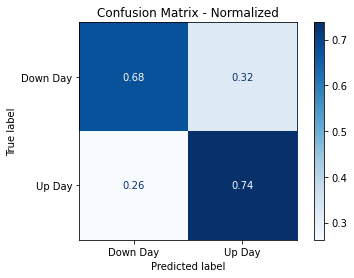

In [23]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

rf_matrix = confusion_matrix(y_test, y_pred)

true_negatives = rf_matrix[0][0]
false_negatives = rf_matrix[1][0]
true_positives = rf_matrix[1][1]
false_positives = rf_matrix[0][1]

accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_negatives + false_positives)
percision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)

print('Accuracy: {}'.format(float(accuracy)))
print('Percision: {}'.format(float(percision)))
print('Recall: {}'.format(float(recall)))
print('Specificity: {}'.format(float(specificity)))

disp = plot_confusion_matrix(rand_frst_clf, X_test, y_test, display_labels = ['Down Day', 'Up Day'], normalize = 'true', cmap=plt.cm.Blues)
disp.ax_.set_title('Confusion Matrix - Normalized')
plt.show()

In [24]:
# Calculate feature importance and store in pandas series
feature_imp = pd.Series(rand_frst_clf.feature_importances_, index=X_Cols.columns).sort_values(ascending=False)
feature_imp

r_percent               0.202493
k_percent               0.196126
RSI                     0.171874
MACD                    0.161598
Price_Rate_Of_Change    0.154109
On Balance Volume       0.113800
dtype: float64

Text(0.5, 1.0, 'Random Forest: Feature Importance Graph')

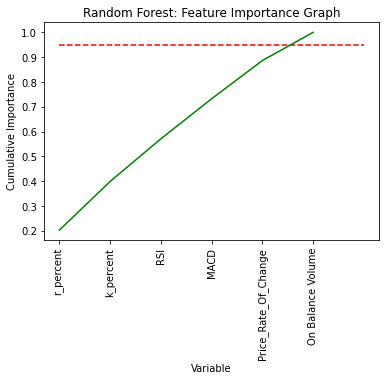

In [25]:
# store the values in a list to plot.
x_values = list(range(len(rand_frst_clf.feature_importances_)))

# Cumulative importances
cumulative_importances = np.cumsum(feature_imp.values)

# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')

# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin = 0, xmax = len(feature_imp), color = 'r', linestyles = 'dashed')

# Format x ticks and labels
plt.xticks(x_values, feature_imp.index, rotation = 'vertical')

# Axis labels and title
plt.xlabel('Variable')
plt.ylabel('Cumulative Importance')
plt.title('Random Forest: Feature Importance Graph')

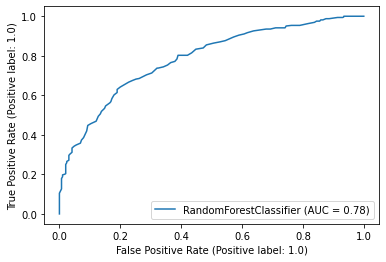

In [26]:
# Create an ROC Curve plot.
rfc_disp = plot_roc_curve(rand_frst_clf, X_test, y_test)
plt.show()
